# Évaluation et Analyse des Résultats

Sur la base des résultats obtenus à partir du fichier `results/result.txt` et de l'exécution de la recherche par grille (`GridSearchCV`), plusieurs modèles ont été entraînés et évalués. Le modèle ayant obtenu les meilleures performances est **Random Forest**.

### 🔍 Meilleur Modèle : Random Forest
**Paramètres optimaux :**
- `max_depth` : `None`
- `min_samples_leaf` : `1`
- `min_samples_split` : `2`
- `n_estimators` : `300`

**Score de validation croisée (CV)** : `0.9438`

Ces résultats ont été obtenus après l'entraînement et l'évaluation de différents modèles de classification (à l'exception de la régression logistique), avec un ajustement automatique des hyperparamètres via `GridSearchCV`.

---

## 🧪 Initialisation des Modèles

Les modèles suivants ont été initialisés avec leurs meilleurs hyperparamètres obtenus lors de la phase de validation :

- `CatBoostClassifier`
- `XGBClassifier`
- `RandomForestClassifier`
- `LGBMClassifier`
- `KNeighborsClassifier`

Ils sont maintenant prêts à être entraînés sur les données d'entraînement, puis évalués à l'aide de différentes métriques de classification (Accuracy, Precision, Recall, F1-Score, Matrice de confusion, ROC et AUC).


In [16]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from MulticlassLogisticRegression import MulticlassLogisticRegression

catboost_model = CatBoostClassifier(depth=7, iterations=1000, learning_rate=0.2,
                                    verbose=0, random_state=42)
xgb_model     = XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200,
                              use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_model      = RandomForestClassifier(n_estimators=300, max_depth=None,
                                       min_samples_split=2, min_samples_leaf=1, random_state=42)
lgbm_model    = LGBMClassifier(learning_rate=0.1, n_estimators=100, num_leaves=100,
                               random_state=42)
knn_model     = KNeighborsClassifier(algorithm='auto', n_neighbors=3, weights='distance')
logistic_model = MulticlassLogisticRegression(alpha=0.01,iterations=1000,use_decay=True,use_l2=True,lambda_=0.1,early_stopping=True,tol=1e-4, decay=0.01)




## 🔧 Import des métriques et définition de la fonction d’évaluation

On commence par importer les métriques et visualisations nécessaires, puis on définit une fonction `evaluate_classification_model()` qui calculera et affichera :

- Accuracy, Precision, Recall, F1-Score  
- Matrice de confusion  
- Courbe ROC et AUC  


In [17]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
def evaluate_multiclass_model(model, X_test, y_test, model_name="Model"):
    # 1. Prédictions et métriques agrégées
    y_pred = model.predict(X_test)
    classes = np.unique(y_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec  = recall_score(y_test, y_pred, average='macro')
    f1   = f1_score(y_test, y_pred, average='macro')
    cm   = confusion_matrix(y_test, y_pred)

    print(f"\nRésultats pour {model_name} :")
    print(f"  • Accuracy    : {acc:.4f}")
    print(f"  • Precision   : {prec:.4f} (macro)")
    print(f"  • Recall      : {rec:.4f} (macro)")
    print(f"  • F1-Score    : {f1:.4f} (macro)")
    print(f"  • Matrice de confusion :\n{cm}\n")

    # 2. Affichage de la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Matrice de confusion — {model_name}")
    plt.tight_layout()
    plt.show()

    # 3. Préparation des scores pour ROC multiclass
    y_bin = label_binarize(y_test, classes=classes)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # 4. Tracé des courbes ROC One-vs-Rest et calcul de l’AUC macro
    plt.figure(figsize=(8, 6))
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        auc_i = roc_auc_score(y_bin[:, i], y_score[:, i])
        aucs.append(auc_i)
        RocCurveDisplay(
            fpr=fpr,
            tpr=tpr,
            roc_auc=auc_i,
            estimator_name=f"Classe {cls}"
        ).plot(ax=plt.gca())

    auc_macro = np.mean(aucs)
    plt.title(f"ROC multiclass — {model_name} (AUC macro = {auc_macro:.2f})")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [18]:
# — Chargement des données —
Path_Data = '../Data/Processed/'
X_train = pd.read_csv(Path_Data + 'X_train.csv')
X_val   = pd.read_csv(Path_Data + 'X_val.csv')
X_test  = pd.read_csv(Path_Data + 'X_test.csv')

y_train = pd.read_csv(Path_Data + 'y_train.csv').values.ravel()
y_val   = pd.read_csv(Path_Data + 'y_val.csv').values.ravel()
y_test  = pd.read_csv(Path_Data + 'y_test.csv').values.ravel()



In [19]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np

def evaluate_multiclass_model_text(model, X_test, y_test, model_name="Model"):

    # 1. Prédictions
    y_pred = model.predict(X_test)
    classes = np.unique(y_test)

    # 2. Calcul des métriques globales
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec  = recall_score(y_test, y_pred, average='macro')
    f1   = f1_score(y_test, y_pred, average='macro')

    # 3. Construction d’un DataFrame résumé
    summary_df = pd.DataFrame({
        'Accuracy': [acc],
        'Precision (macro)': [prec],
        'Recall (macro)': [rec],
        'F1-Score (macro)': [f1]
    }, index=[model_name])
    print(f"\n=== Résumé des métriques pour {model_name} ===")
    print(summary_df.to_string(float_format='%.4f'))

    # 4. Rapport de classification détaillé
    print(f"\n=== Classification report pour {model_name} ===")
    print(classification_report(y_test, y_pred, digits=4))

    # 5. Matrice de confusion comme DataFrame
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    print(f"\n=== Matrice de confusion pour {model_name} ===")
    print(cm_df)

    # 6. Calcul de l’AUC macro One-vs-Rest
    #    On binarise d’abord les étiquettes réelles
    y_bin = label_binarize(y_test, classes=classes)
    #    On récupère les scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    #    AUC macro (multi_class='ovr')
    auc_macro = roc_auc_score(
        y_bin, y_score,
        average='macro',
        multi_class='ovr'
    )
    print(f"\n=== AUC macro One-vs-Rest pour {model_name} : {auc_macro:.4f} ===\n")



====> LogisticRegression <====
Training multi-class classifier with 7 classes
Training classifier for class 0 (1/7)
Early stopping at iteration 281
  - Training accuracy for class 0: 0.7175
Training classifier for class 1 (2/7)
Early stopping at iteration 57
  - Training accuracy for class 1: 0.6152
Training classifier for class 2 (3/7)
Early stopping at iteration 689
  - Training accuracy for class 2: 0.9497
Training classifier for class 3 (4/7)
Early stopping at iteration 768
  - Training accuracy for class 3: 0.9952
Training classifier for class 4 (5/7)
Early stopping at iteration 735
  - Training accuracy for class 4: 0.9839
Training classifier for class 5 (6/7)
Early stopping at iteration 718
  - Training accuracy for class 5: 0.9702
Training classifier for class 6 (7/7)
Early stopping at iteration 704
  - Training accuracy for class 6: 0.9645
Training complete in 95.93 seconds

Résultats pour LogisticRegression :
  • Accuracy    : 0.6395
  • Precision   : 0.2814 (macro)
  • Reca

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


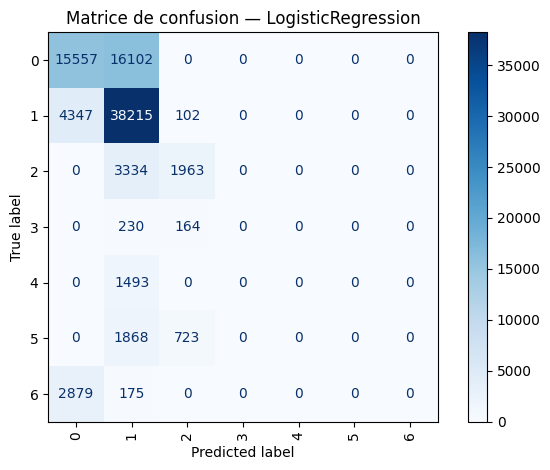

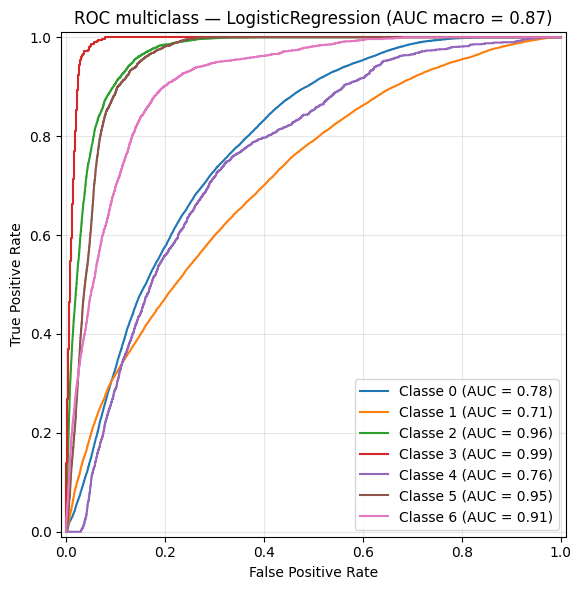


====> CatBoost <====

Résultats pour CatBoost :
  • Accuracy    : 0.9264
  • Precision   : 0.9174 (macro)
  • Recall      : 0.8917 (macro)
  • F1-Score    : 0.9037 (macro)
  • Matrice de confusion :
[[28673  2840     0     0    21     6   119]
 [ 1923 40458    98     0    97    68    20]
 [    2   112  4980    31     2   170     0]
 [    0     0    36   339     0    19     0]
 [   12   278    36     0  1154    13     0]
 [    4    94   193    13     1  2286     0]
 [  189    18     0     0     1     0  2846]]



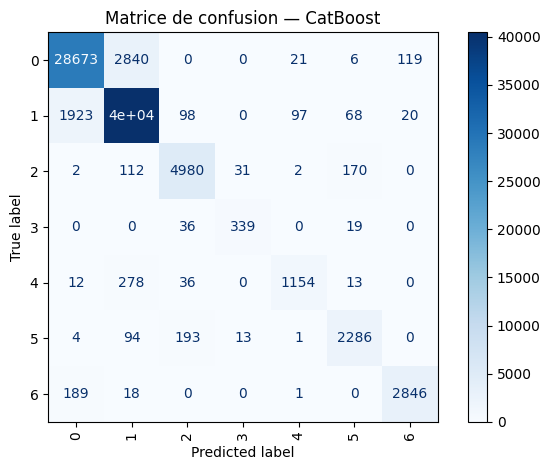

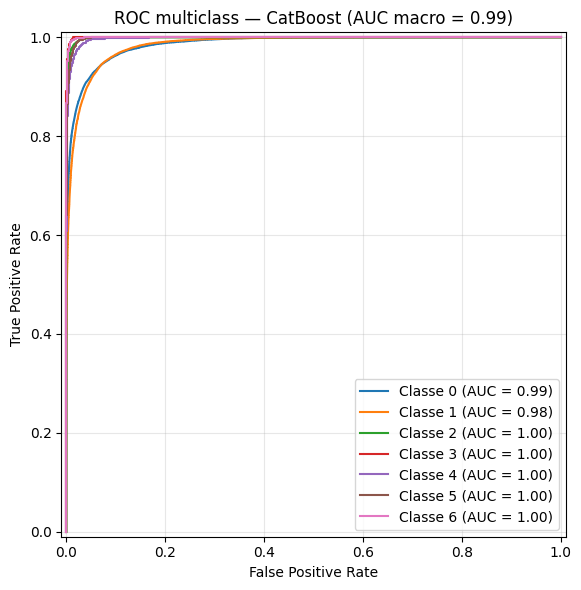


====> XGBoost <====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Résultats pour XGBoost :
  • Accuracy    : 0.9106
  • Precision   : 0.9168 (macro)
  • Recall      : 0.8893 (macro)
  • F1-Score    : 0.9018 (macro)
  • Matrice de confusion :
[[28017  3534     0     0    16     4    88]
 [ 2717 39665    95     0    84    86    17]
 [    2   113  4992    27     3   160     0]
 [    0     0    34   344     0    16     0]
 [   18   314    33     0  1117    11     0]
 [    1    84   171    14     1  2320     0]
 [  137    11     0     0     1     0  2905]]



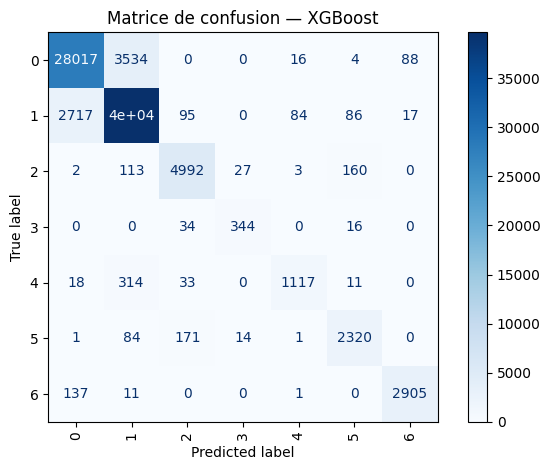

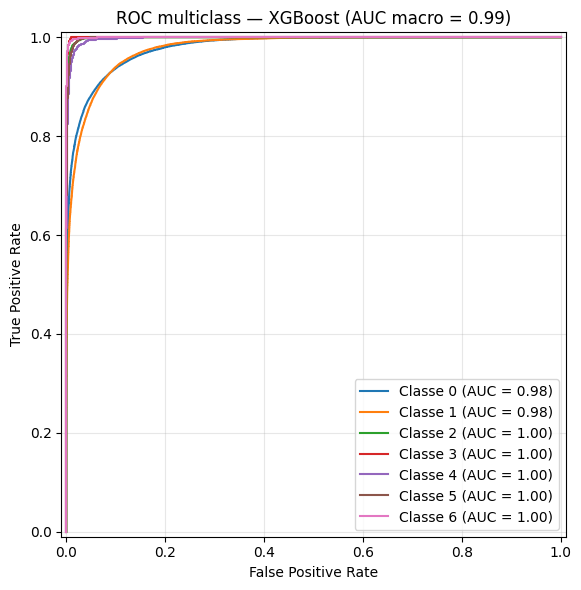


====> RandomForest <====

Résultats pour RandomForest :
  • Accuracy    : 0.9525
  • Precision   : 0.9395 (macro)
  • Recall      : 0.9009 (macro)
  • F1-Score    : 0.9186 (macro)
  • Matrice de confusion :
[[29765  1812     0     0    11     5    66]
 [  938 41501    90     0    65    53    17]
 [    3    90  5077    24     4    99     0]
 [    0     0    53   330     0    11     0]
 [   28   303    24     0  1127    11     0]
 [    4    74   173    15     1  2324     0]
 [  148    18     0     0     0     0  2888]]



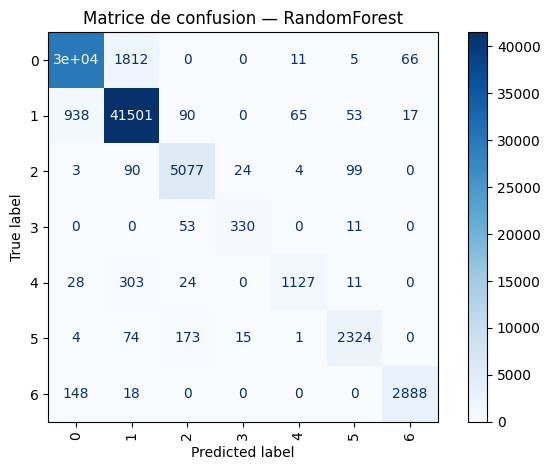

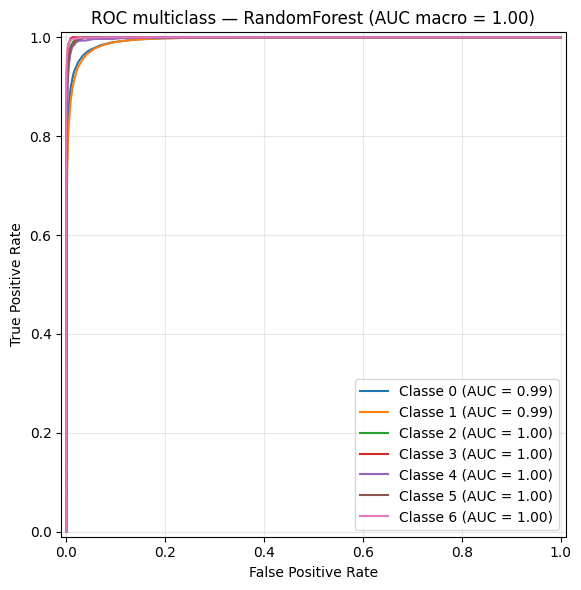


====> LightGBM <====
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 406708, number of used features: 53
[LightGBM] [Info] Start training from score -1.008966
[LightGBM] [Info] Start training from score -0.718703
[LightGBM] [Info] Start training from score -2.784590
[LightGBM] [Info] Start training from score -5.339241
[LightGBM] [Info] Start training from score -4.128325
[LightGBM] [Info] Start training from score -3.511590
[LightGBM] [Info] Start training from score -3.338024

Résultats pour LightGBM :
  • Accuracy    : 0.9129
  • Precision   : 0.8872 (macro)
  • Recall      : 0.8796 (macro)
  • F1-Score    : 0.8824 (macro)
  • Matrice de confusion :
[[28022  3507     3     8    16     6    97]
 [ 2435 39876   100    

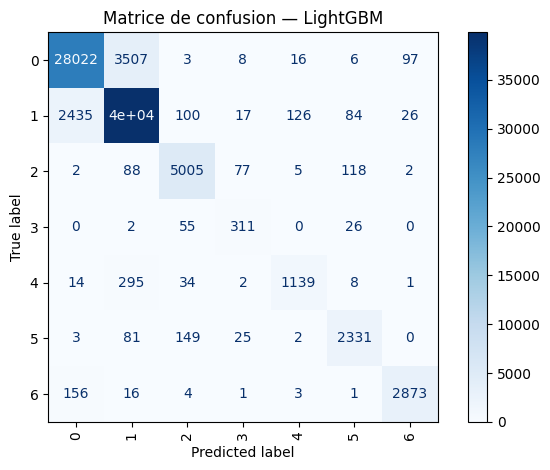

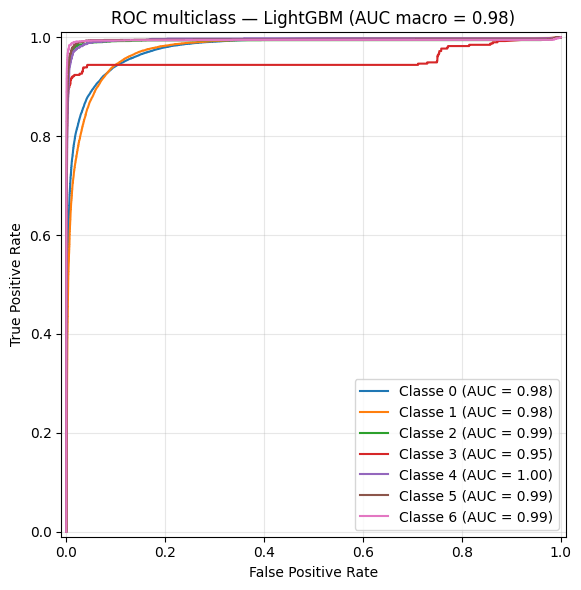


====> KNN <====

Résultats pour KNN :
  • Accuracy    : 0.9311
  • Precision   : 0.8876 (macro)
  • Recall      : 0.8726 (macro)
  • F1-Score    : 0.8797 (macro)
  • Matrice de confusion :
[[29394  2066     1     0    35    17   146]
 [ 1777 40410   118     1   199   136    23]
 [    4   124  4851    38    12   268     0]
 [    0     0    63   298     0    33     0]
 [   38   237    23     0  1184    11     0]
 [    8   129   283    19     5  2147     0]
 [  165    21     0     0     1     0  2867]]



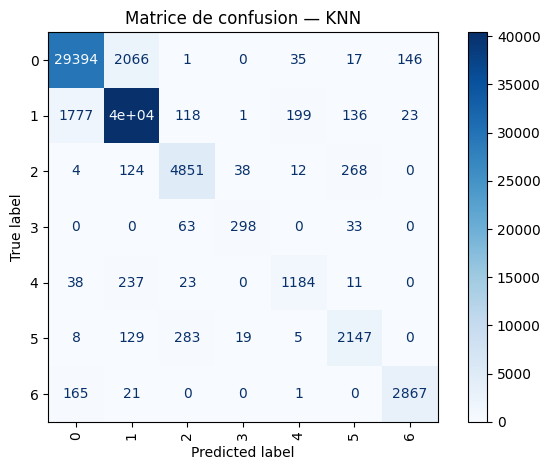

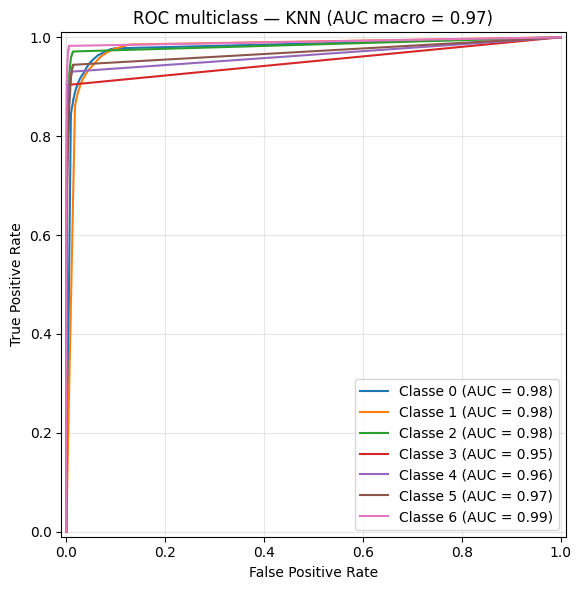


✅ Tous les paramètres de chaque modèle ont été enregistrés dans params.json


In [20]:
import json

models = [
    ("LogisticRegression",logistic_model),
    ("CatBoost",      catboost_model),
    ("XGBoost",       xgb_model),
    ("RandomForest",  rf_model),
    ("LightGBM",      lgbm_model),
    ("KNN",           knn_model)
]

saved_params = {}

for name, model in models:
    print(f"\n====> {name} <====")
    model.fit(X_train, y_train)
    
    # Choose the right evaluation function:
    # If you use the text-only version:
    # evaluate_multiclass_model_text(model, X_test, y_test, model_name=name)
    # Otherwise, if you still want the plots:
    evaluate_multiclass_model(model, X_test, y_test, model_name=name)

    # Save either the grid-search best params, or the model's default params:
    if hasattr(model, "best_params_"):
        saved_params[name] = model.best_params_
    else:
        saved_params[name] = model.get_params()

# Write out to JSON, converting any non-native types if needed
with open('params.json', 'w') as f:
    json.dump(saved_params, f, indent=4, default=int)

print("\n✅ Tous les paramètres de chaque modèle ont été enregistrés dans params.json")
